In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import re
from config import *

# Sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, HDBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.base import clone
import umap

# Visual
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from itertools import permutations 
from tqdm import tqdm

/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
AgglomerativeClustering()

In [146]:
features = pd.read_parquet(FEATURES_DIR / "features.pq").query("y==1")
features_with_info = features
features = features.drop(["participant_id", "y"], axis=1)
features = features.dropna()
features_stdz = pd.DataFrame(StandardScaler().fit_transform(features.values), columns=features.columns)

gaussian_mixture_model_args = {'n_components': None,'covariance_type':'full', 'reg_covar':1e-3, 'init_params':'k-means++', 'random_state':42}
agglomerative_model_args = {'n_clusters': None}
hdbscan_model_args = {}

np.random.seed(42)

In [149]:
def brute_force_cluster_range(clustering_model, model_args: dict, X:pd.DataFrame, choose_k: int = 2, n_cluster_min: int = 2, n_cluster_max: int = 10) -> pd.DataFrame:
    """Brute forces by combining n_choose_k features

    Args:
        model (sklearn clustering model): Model must have the n_clusters hyperparameter
        choose_k (int, optional): _description_. Defaults to 2.
        n_cluster_min (int, optional): _description_. Defaults to 2.
        n_cluster_max (int, optional): _description_. Defaults to 10.
        
    Returns:
        pd.DataFrame
    """
    combinations = list(permutations(X.columns, choose_k))

    silhouette_scores = []
    cluster_features = []
    n_clusters = []

    for n_cluster in range(n_cluster_min, n_cluster_max):
        if 'n_clusters' in model_args.keys():
            model_args["n_clusters"] = n_cluster
        elif 'n_components' in model_args.keys():
            model_args["n_components"] = n_cluster

        
        logging.info(f"n_cluster: {n_cluster}")
        model = clustering_model(**model_args)
        for combination in tqdm(combinations):
            X_selected_featues = X[list(combination)]
            model.fit(X_selected_featues)
            
            
            try: 
                labels = model.labels_
            except:
                labels = model.predict(X_selected_featues)
            
            sil_score = silhouette_score(X_selected_featues, labels)

            silhouette_scores.append(sil_score)
            cluster_features.append(list(combination))
            n_clusters.append(n_cluster)
    
    df_return = pd.DataFrame({
        'silhouette_scores': silhouette_scores,
        'cluster_features': cluster_features,
        'n_clusters': n_clusters,
    })
    
    return (df_return
     .assign(max_score=df_return.groupby('n_clusters')['silhouette_scores'].transform('max'))
     .query("max_score == silhouette_scores") 
     .drop(columns="max_score")
     .reset_index(drop=True)
    )

def brute_force_cluster(clustering_model, model_args: dict, X:pd.DataFrame, choose_k: int = 2) -> pd.DataFrame:
    """Brute forces by combining n_choose_k features

    Args:
        model (sklearn clustering model): Model must have the n_clusters hyperparameter
        choose_k (int, optional): _description_. Defaults to 2.
        n_cluster_min (int, optional): _description_. Defaults to 2.
        n_cluster_max (int, optional): _description_. Defaults to 10.
        
    Returns:
        pd.DataFrame
    """
    combinations = list(permutations(X.columns, choose_k))

    silhouette_scores = []
    cluster_features = []
    n_clusters = []

    model = clustering_model(**model_args)
    
    for combination in tqdm(combinations):
        X_selected_featues = X[list(combination)]
        model.fit(X_selected_featues)
        
        try: 
            labels = model.labels_
        except:
            labels = model.predict(X_selected_featues)
        
        n_labels = len(np.unique(labels))
        
        if n_labels == 1:
            continue
        
        sil_score = silhouette_score(X_selected_featues, labels)

        silhouette_scores.append(sil_score)
        cluster_features.append(list(combination))
        n_clusters.append(n_labels)
    
    df_return = pd.DataFrame({
        'silhouette_scores': silhouette_scores,
        'cluster_features': cluster_features,
        'n_clusters': n_clusters,
    })
    
    return (df_return
     .assign(max_score=df_return.groupby('n_clusters')['silhouette_scores'].transform('max'))
     .query("max_score == silhouette_scores") 
     .drop(columns="max_score")
     .sort_values("n_clusters")
     .reset_index(drop=True)
    )

def add_features_to_cluster_model(df: pd.DataFrame, X: pd.DataFrame, clustering_model, model_args:dict, patience: int = 0) -> pd.DataFrame:
    chosen_features = []
    chosen_n_clusters = []
    chosen_silhouette_scores = []
    chosen_models = []
    chosen_n_features = []
    
    for i, (brute_force_sil_score, brute_force_features, brute_force_n_cluster) in df.iterrows():
        logging.info(f"\n\nTesting for {brute_force_n_cluster} clusters")
        logging.info(f"Score to beat: {brute_force_sil_score}")
        logging.info(f"Model starts with features {brute_force_features}")
        
        best_overall_features = brute_force_features
        best_overall_sil_score = brute_force_sil_score
        best_overall_n_clusters = brute_force_n_cluster
        features_to_test = X.copy()
        features_to_test = features_to_test.drop(best_overall_features, axis=1).columns.to_list()
        n_features_left_to_test = len(features_to_test)
        
        best_features = best_overall_features.copy()
        logging.info(f"Best features now contain {best_features}")
        logging.info(f"Best overall features now contain {best_overall_features}")
        
        patience_counter = 0

        while (n_features_left_to_test > 0) and (patience_counter <= patience):
            logging.info(f"Patience counter: {patience_counter}\n\n")
            best_sil_score = 0
            best_feature_added = None
            best_n_clusters = 0
            
            for feature in features_to_test:
                feature_to_test_including_brute = list(np.unique([feature] + best_features))
                
                X_select: pd.DataFrame = X[feature_to_test_including_brute]
                if 'n_clusters' in model_args.keys():
                    model_args["n_clusters"] = brute_force_n_cluster
                elif 'n_components' in model_args.keys():
                    model_args["n_components"] = brute_force_n_cluster
                model = clustering_model(**model_args)
                
                model.fit(X_select)
                try: 
                    labels = model.labels_
                except:
                    labels = model.predict(X_select)
                n_labels = len(np.unique(labels))
                
                if n_labels == 1:
                    continue
                sil_score = silhouette_score(X_select, labels)
                
                if best_sil_score < sil_score:
                    logging.info(f"New best sil score: {best_sil_score} -> {sil_score}")
                    best_sil_score = sil_score
                    best_feature_added = feature
                    best_n_clusters = n_labels
                
            logging.info(f"New best feature added: {best_feature_added}")
            best_features += [best_feature_added]
            logging.info(f"Best features: {best_features}")
            features_to_test.remove(best_feature_added)
            n_features_left_to_test = len(features_to_test)

            if best_overall_sil_score < best_sil_score:
                logging.info(f"New best !!overall!! sil score: {best_overall_sil_score} -> {best_sil_score}")
                best_overall_sil_score = best_sil_score
                best_overall_features += [best_feature_added]
                best_overall_n_clusters = best_n_clusters
            patience_counter += 1
        
        logging.info(f"Best overall features: {best_overall_features}")
        
        chosen_features.append(best_overall_features)
        chosen_n_clusters.append(best_overall_n_clusters)
        chosen_silhouette_scores.append(best_overall_sil_score)
        chosen_n_features.append(len(best_overall_features))
    
    


    df_return = pd.DataFrame({
        'chosen_features': chosen_features, 
        'chosen_n_clusters': chosen_n_clusters,
        'chosen_silhouette_scores': chosen_silhouette_scores,
        'chosen_n_features': chosen_n_features
    })    
    
    
    return (df_return
     .assign(max_score=df_return.groupby('chosen_n_clusters')['chosen_silhouette_scores'].transform('max'))
     .query("max_score == chosen_silhouette_scores") 
     .drop(columns="max_score")
     .sort_values("chosen_n_clusters")
     .reset_index(drop=True)
    )

def remove_redundant_rows(df: pd.DataFrame):
    already_seen_features = []
    already_seen_rows = []

    for i, row in df.iterrows():
        sorted_feature_names = sorted(row["cluster_features"])
        if sorted_feature_names in already_seen_features:
            continue
        already_seen_rows.append(row)
        already_seen_features.append(sorted_feature_names)

    return pd.DataFrame(already_seen_rows).reset_index(drop=True)
        
def plot_scatter_of_clusters(X, clustering_model = None, reducer=None, labels=None , arrows:bool=True, ax=None):
    coeff = None
    n_features_provided = X.shape[1]
    if reducer is not None and n_features_provided > 2:
        X_reduced = reducer.fit_transform(X)
        if "PCA" in reducer.__str__():
            coeff = reducer.components_
        X_reduced_df = pd.DataFrame({"Component 1": X_reduced[:,0]
                                ,'Component 2': X_reduced[:,1]})
    else:
        if n_features_provided != 2:
            raise ValueError('Dimensionality reduction method must be provided when number of features are not 2')
        X_reduced_df = X

    x_var_name, y_var_name = X_reduced_df.columns

    if clustering_model is not None:
        try: 
            clustering_labels = clustering_model.labels_
        except:
            clustering_labels = clustering_model.predict(X)
            
        X_reduced_df["cluster"] = clustering_labels

        sns.scatterplot(X_reduced_df, x=x_var_name, y=y_var_name, hue='cluster', ax=ax)
        ax.set_title(f"Silhouette score: {round(silhouette_score(X, clustering_labels),5)}\nn_clusters: {len(np.unique(clustering_labels))}")
        
    else:
        sns.scatterplot(X_reduced_df, x=x_var_name, y=y_var_name,ax=ax)
    
    if coeff is not None and arrows:
        n = coeff.shape[1]
        for i in range(n):
            plt.arrow(0, 0, coeff[0,i]*5, coeff[1,i]*5,color = 'r',alpha = 0.5)
            if labels is None:
                plt.text(coeff[0,i]* 5, coeff[1,i] * 5, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
            else:
                print(labels[i])
                plt.text(coeff[0,i]* 5, coeff[1,i] * 5, labels[i], color = 'g', ha = 'center', va = 'center')
             
def run_clustering_tuning(model, model_args, X: pd.DataFrame, choose_k: int = 2, n_cluster_min: int = 2, n_cluster_max: int = 10, patience: int = 0):
    logging.info(f"Starting tuning for {str(model)}")
    if "HDBSCAN" in str(model):
        df_brute = brute_force_cluster(model, {}, X, choose_k)
    else:
        df_brute = brute_force_cluster_range(model, model_args.copy(), X, choose_k=choose_k,n_cluster_min=2,n_cluster_max=15)

    df_brute = remove_redundant_rows(df_brute)


    df_added_features = add_features_to_cluster_model(df=df_brute,
                                X=X,
                                clustering_model=model,
                                model_args = model_args.copy(),
                                patience=patience)
    df_added_features["model_method"] = str(model)
    
    
    return df_added_features

def plot_all_models(model, model_args, df: pd.DataFrame, reducer) -> pd.DataFrame:
    nrows_in_df = df.shape[0]
    nrows_in_plot = int(np.ceil(nrows_in_df/4))
    fig, axs = plt.subplots(figsize=(20,nrows_in_plot*4), nrows= nrows_in_plot , ncols=min(nrows_in_df, 4))

    axs = np.array(axs).reshape(-1)
    
    for i, (chosen_features, chosen_n_clusters, chosen_silhouette_scores, chosen_n_features, chosen_model_method) in df.iterrows():
        X_selected = features_stdz[chosen_features]
        
        if 'n_clusters' in model_args.keys():
            model_args["n_clusters"] = chosen_n_clusters
        elif 'n_components' in model_args.keys():
            model_args["n_components"] = chosen_n_clusters
        
        clustering_model = model(**model_args)
        clustering_model.fit(X_selected)

        plot_scatter_of_clusters(X=features_stdz[chosen_features]
                                , clustering_model=clustering_model
                                , reducer=reducer
                                , labels=chosen_features
                                , ax=axs[i])
    fig.suptitle(f"Model: {chosen_model_method}")
    fig.subplots_adjust(top=0.88)
    plt.tight_layout()
    


In [150]:
df_gm = run_clustering_tuning(GaussianMixture, gaussian_mixture_model_args, features_stdz)
df_agg = run_clustering_tuning(AgglomerativeClustering, agglomerative_model_args, features_stdz)
df_hdbscan = run_clustering_tuning(HDBSCAN, hdbscan_model_args, features_stdz, patience=2)

2025-05-05 10:09:35,614 - INFO - 900962908.run_clustering_tuning:262 - Starting tuning for <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
2025-05-05 10:09:35,615 - INFO - 900962908.brute_force_cluster_range:26 - n_cluster: 2
100%|██████████| 2756/2756 [00:06<00:00, 409.23it/s]
2025-05-05 10:09:42,352 - INFO - 900962908.brute_force_cluster_range:26 - n_cluster: 3
100%|██████████| 2756/2756 [00:08<00:00, 327.00it/s]
2025-05-05 10:09:50,781 - INFO - 900962908.brute_force_cluster_range:26 - n_cluster: 4
100%|██████████| 2756/2756 [00:09<00:00, 276.94it/s]
2025-05-05 10:10:00,734 - INFO - 900962908.brute_force_cluster_range:26 - n_cluster: 5
100%|██████████| 2756/2756 [00:11<00:00, 242.43it/s]
2025-05-05 10:10:12,103 - INFO - 900962908.brute_force_cluster_range:26 - n_cluster: 6
100%|██████████| 2756/2756 [00:12<00:00, 222.81it/s]
2025-05-05 10:10:24,473 - INFO - 900962908.brute_force_cluster_range:26 - n_cluster: 7
100%|██████████| 2756/2756 [00:13<00:00, 205.37it/s]
2025-05-0

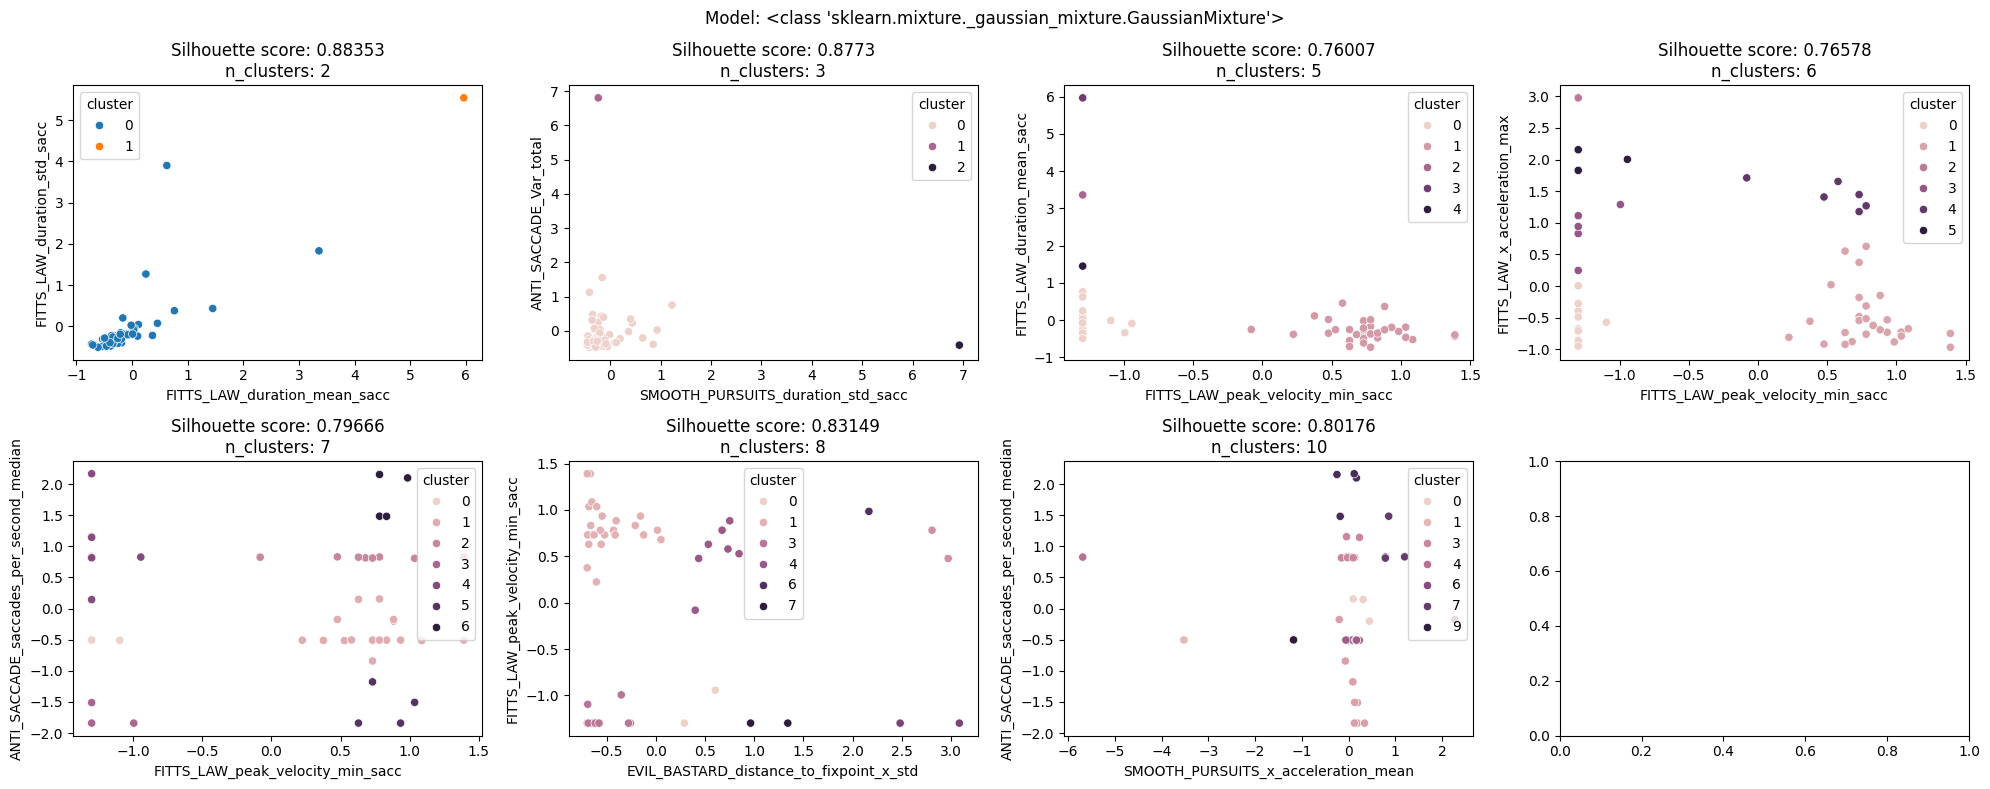

In [152]:
plot_all_models(GaussianMixture, gaussian_mixture_model_args, df_gm, reducer=PCA(n_components=2))

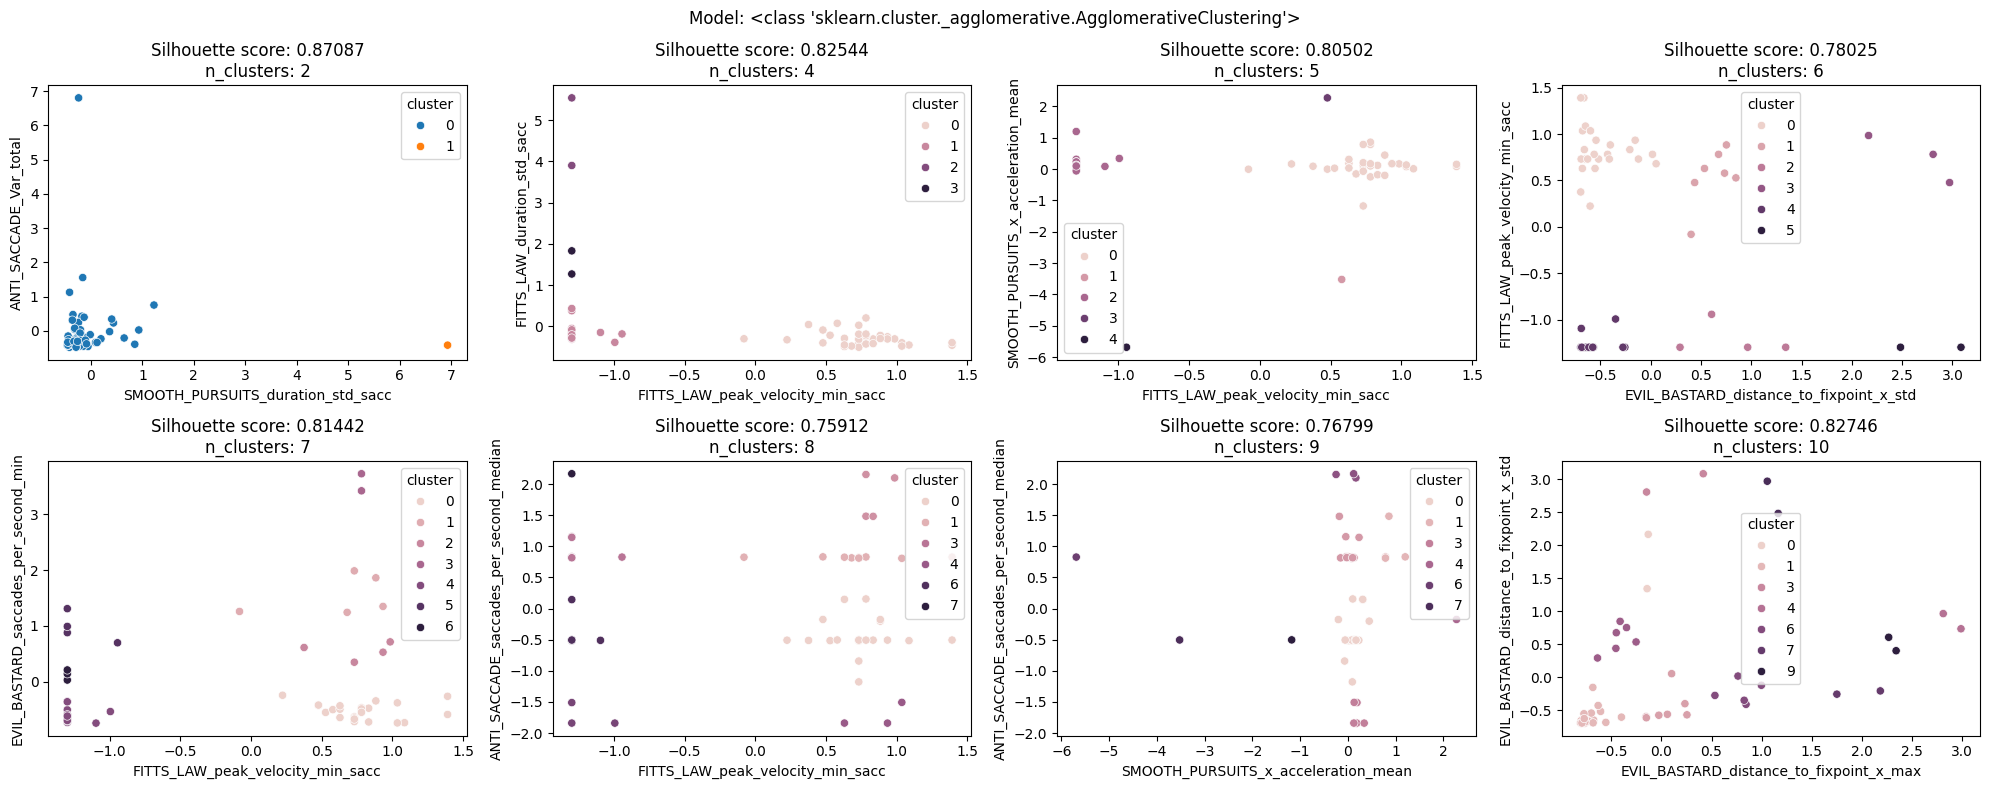

In [153]:
plot_all_models(AgglomerativeClustering, agglomerative_model_args, df_agg, reducer = PCA(n_components=2))

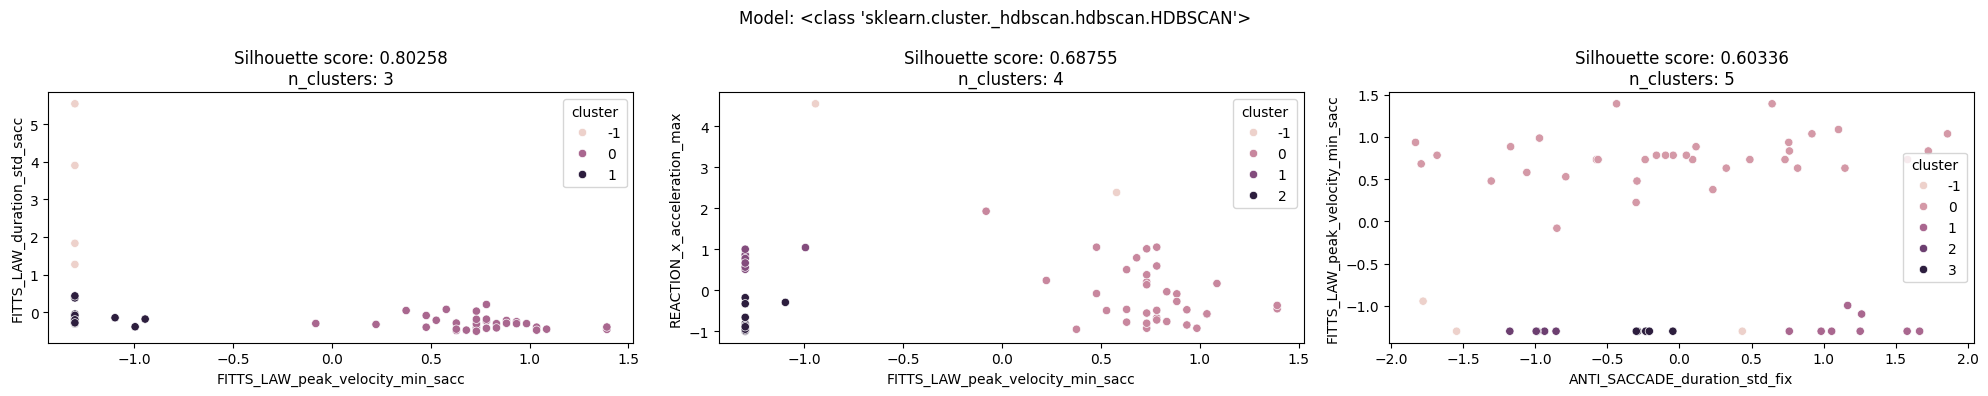

In [154]:
plot_all_models(HDBSCAN,  hdbscan_model_args, df_hdbscan, reducer = PCA(n_components=2))

In [156]:
df_all = pd.concat([df_gm, df_agg, df_hdbscan])
best_model = df_all["chosen_silhouette_scores"].idxmax()

df_all.iloc[[best_model]]


,chosen_features,chosen_n_clusters,chosen_silhouette_scores,chosen_n_features,model_method
0,"[FITTS_LAW_duration_mean_sacc, FITTS_LAW_durat...",2,0.882418,2,<class 'sklearn.mixture._gaussian_mixture.Gaus...


# Dimensionality reduction

In [160]:
 
def plot_scatter_dimensionality_reduction(X, reducer=None, labels=None , arrows:bool=True, ax=None):
    coeff = None
    n_features_provided = X.shape[1]
    if reducer is not None and n_features_provided > 2:
        X_reduced = reducer.fit_transform(X)
        if "PCA" in reducer.__str__():
            coeff = reducer.components_
        X_reduced_df = pd.DataFrame({"Component 1": X_reduced[:,0]
                                ,'Component 2': X_reduced[:,1]})
    else:
        if n_features_provided != 2:
            raise ValueError('Dimensionality reduction method must be provided when number of features are not 2')
        X_reduced_df = X

    x_var_name, y_var_name = X_reduced_df.columns

    sns.scatterplot(X_reduced_df, x=x_var_name, y=y_var_name,ax=ax)
    if "umap" in reducer.__str__().lower():
        title_reducer = "UMAP()"
    else:
        title_reducer = reducer.__str__().upper()
    ax.set_title(f"Method: {title_reducer}")
    if coeff is not None and arrows:
        n = coeff.shape[1]
        for i in range(n):
            plt.arrow(0, 0, coeff[0,i]*5, coeff[1,i]*5,color = 'r',alpha = 0.5)
            if labels is None:
                plt.text(coeff[0,i]* 5, coeff[1,i] * 5, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
            else:
                print(labels[i])
                plt.text(coeff[0,i]* 5, coeff[1,i] * 5, labels[i], color = 'g', ha = 'center', va = 'center')
       

/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


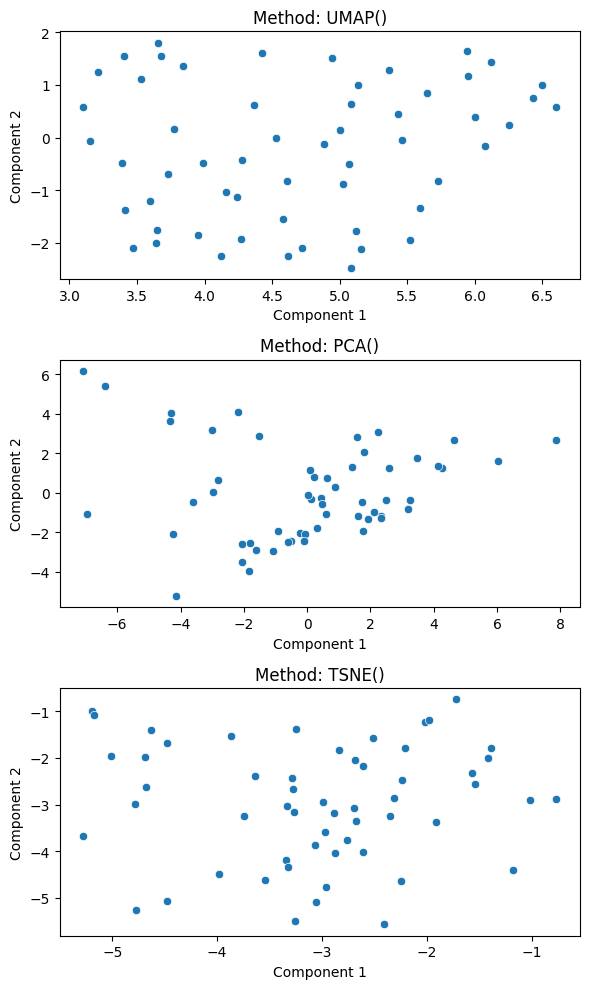

In [161]:
features_both = pd.read_parquet(FEATURES_DIR / "features.pq").query("y==1").drop(["participant_id", "y"], axis=1).dropna()
features_both_stdz = pd.DataFrame(StandardScaler().fit_transform(features_both), columns=features_both.columns)

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,10))
plot_scatter_dimensionality_reduction(features_both_stdz, reducer=umap.UMAP(), arrows=False, ax=axs[0])
plot_scatter_dimensionality_reduction(features_both_stdz, reducer=PCA(), arrows=False, ax=axs[1])
plot_scatter_dimensionality_reduction(features_both_stdz, reducer=TSNE(), ax=axs[2])
fig.tight_layout()


/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


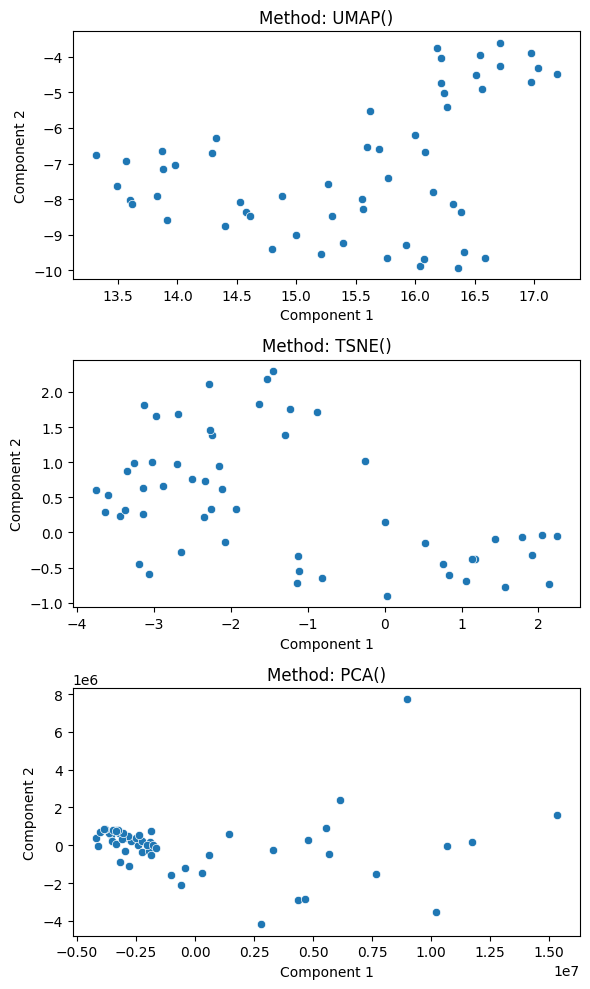

In [162]:
all_features = pd.read_parquet(FEATURES_DIR / "all_features.pq").query("y==1").drop(["participant_id", "y"], axis=1).dropna()
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(6,10))
plot_scatter_dimensionality_reduction(all_features, reducer=umap.UMAP(), ax=axs[0])
plot_scatter_dimensionality_reduction(all_features, reducer=TSNE(), arrows=False, ax=axs[1])
plot_scatter_dimensionality_reduction(all_features, reducer=PCA(), arrows=False, ax=axs[2])
plt.tight_layout()